In [1]:
%matplotlib notebook
import napari
import numpy as np
from scipy import spatial, stats
import math
import matplotlib.pyplot as plt

In [2]:
# a = np.random.uniform(low=0, high=100, size=(10,10,10))
# a = np.where(a < 98, 0, 1)
# nonzero_a = np.nonzero(a)
# print(nonzero_a)
# b = np.random.uniform(low=0, high=100, size=(10,10,10))
# b = np.where(b <= 99, 0, 1)
# nonzero_b = np.nonzero(b)

In [19]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1-point2)

In [3]:
random_points = stats.uniform.rvs(0, 100, (100,3))
x = random_points[:,0]
y = random_points[:,1]
z = random_points[:,2]


In [22]:
print(euclidean_distance(np.array((10,10,10)),np.array((0,0,0))))

17.320508075688775


<IPython.core.display.Javascript object>


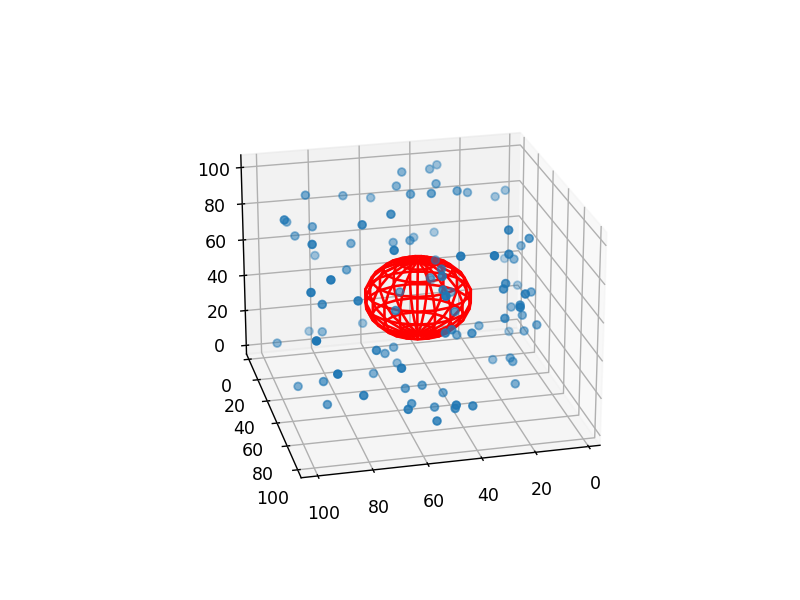

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x,y,z,cmap='Blues')

scale = 20
# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
cx = scale*np.cos(u)*np.sin(v)+50
cy = scale*np.sin(u)*np.sin(v)+50
cz = scale*np.cos(v)+50
ax.plot_wireframe(cx, cy, cz, color="r")


In [5]:
x_min = 0; x_max = 100
y_min = 0; y_max = 100
z_min = 0; z_max = 100
total_volume = (x_max - x_min)*(y_max - y_min)*(z_max - z_min)

In [6]:
# Currently using x_max-x_min as maximum radius, by convention it should be sqrt(x_max-x_min/2)
radii = np.linspace(0,x_max-x_min,50).reshape(50,1)

In [7]:
tree = spatial.cKDTree(random_points)
indices = tree.query_ball_point((50,50,50),20)

random_points[indices]

[14, 16, 0, 77]


array([[41.49741516, 34.50175159, 51.38771612],
       [54.91069354, 41.14745741, 48.9335952 ],
       [38.99372992, 62.25590408, 47.5294141 ],
       [62.0983378 , 65.28763548, 52.98997486]])

In [ ]:
def make_tree(d1=None, d2=None, d3=None):
    active_dimensions = [dimension for dimension in [d1,d2,d3] if dimension is not None]
    assert len(active_dimensions) > 0, "Must have at least 1-dimension to make tree"
    if len(active_dimensions)==1:
        points = np.c_[active_dimensions[0].ravel()]
    elif len(active_dimensions)==2:
        points = np.c_[active_dimensions[0].ravel(), active_dimensions[1].ravel()]
    else:
        points = np.c_[active_dimensions[0].ravel(), active_dimensions[1].ravel(), active_dimensions[2].ravel()]
    return spatial.cKDTree(points), len(active_dimensions)

In [ ]:
def calculate_ripley(radii, sample_size, d1=None, d2=None, d3=None, sample_shape='circle', boundary_correct=False, CSR_Normalise=False):
    results = []
    tree, dimensions = make_tree(d1=d1, d2=d2, d3=d3)
    if type(radii) is not list:
        radii = [radii]
    for radius in radii:
        
        score_vol = (4/3) * np.pi * radius**3
        
        if sample_shape=='circle':
            bound_size = (4/3) * np.pi * sample_size**3
        elif sample_shape=='rectangle':
            bound_size = sample_size[0]*sample_size[1]*sample_size[2]
        counts = 0
        for x, y, z in zip(d1, d2, d3):
            if boundary_correct:
                vol = calculate_overlap([x,y,z], sample_size, radius, sample_shape, dimensions)
                boundary_correction = vol/score_vol
                counts += (len(tree.query_ball_point([x,y,z], radius))-1)/boundary_correction
            else:
                counts += len(tree.query_ball_point([x,y,z], radius))-1
                    
        if CSR_Normalise:
            results.append((bound_size*counts/len(d1)**2) - score_vol)
        else:
            results.append(bound_size*counts/len(d1)**2)
    if len(results)==1:
        return results[0]
    else:
        return results